In [1]:
import os

from warnings import simplefilter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble
from sklearn.preprocessing import Imputer, RobustScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
%matplotlib inline
import matplotlib.pyplot as plt

# Part 1 Data Exploration

In [2]:
# reading Data
df = pd.read_csv("loans.csv")
# check first five observations of the data set
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,0.0,0.0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,0.0,0.0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,0.0,0.0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,0.0,0.0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,1.0,0.0,0


In [3]:
# row count 
print "Num of rows: " + str(df.shape[0])
# col count
print "Num of columns: " + str(df.shape[1]) 
# Missing Value
print df.isnull().sum()
print df.dtypes

Num of rows: 9578
Num of columns: 14
credit.policy         0
purpose               0
int.rate              0
installment           0
log.annual.inc        4
dti                   0
fico                  0
days.with.cr.line    29
revol.bal             0
revol.util           62
inq.last.6mths       29
delinq.2yrs          29
pub.rec              29
not.fully.paid        0
dtype: int64
credit.policy          int64
purpose               object
int.rate             float64
installment          float64
log.annual.inc       float64
dti                  float64
fico                   int64
days.with.cr.line    float64
revol.bal              int64
revol.util           float64
inq.last.6mths       float64
delinq.2yrs          float64
pub.rec              float64
not.fully.paid         int64
dtype: object


## check for distribution

positive example: 1533
negative example 8045


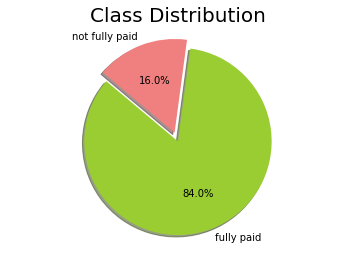

In [4]:
# Distribution of the positive and negative examples
pos = df[df["not.fully.paid"] == 1].shape[0]
neg = df[df["not.fully.paid"] == 0].shape[0]
print "positive example:", pos
print "negative example", neg
labels = ["fully paid", "not fully paid"]
sizes = [neg, pos]
colors = ['yellowgreen', 'lightcoral']
explode = (0, 0.1) 
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Class Distribution", y=1, fontdict={"fontsize": 20})
plt.show()

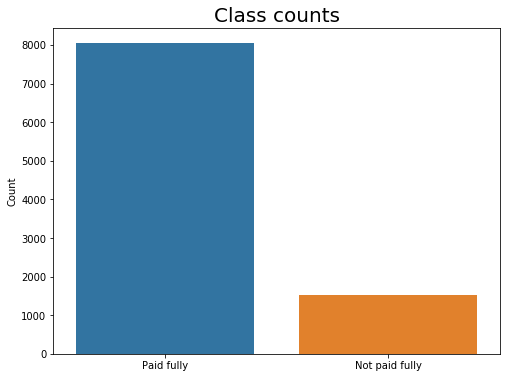

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(df["not.fully.paid"])
plt.xticks((0, 1), ["Paid fully", "Not paid fully"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});

/anaconda2/envs/laidata1/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda2/envs/laidata1/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda2/envs/laidata1/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


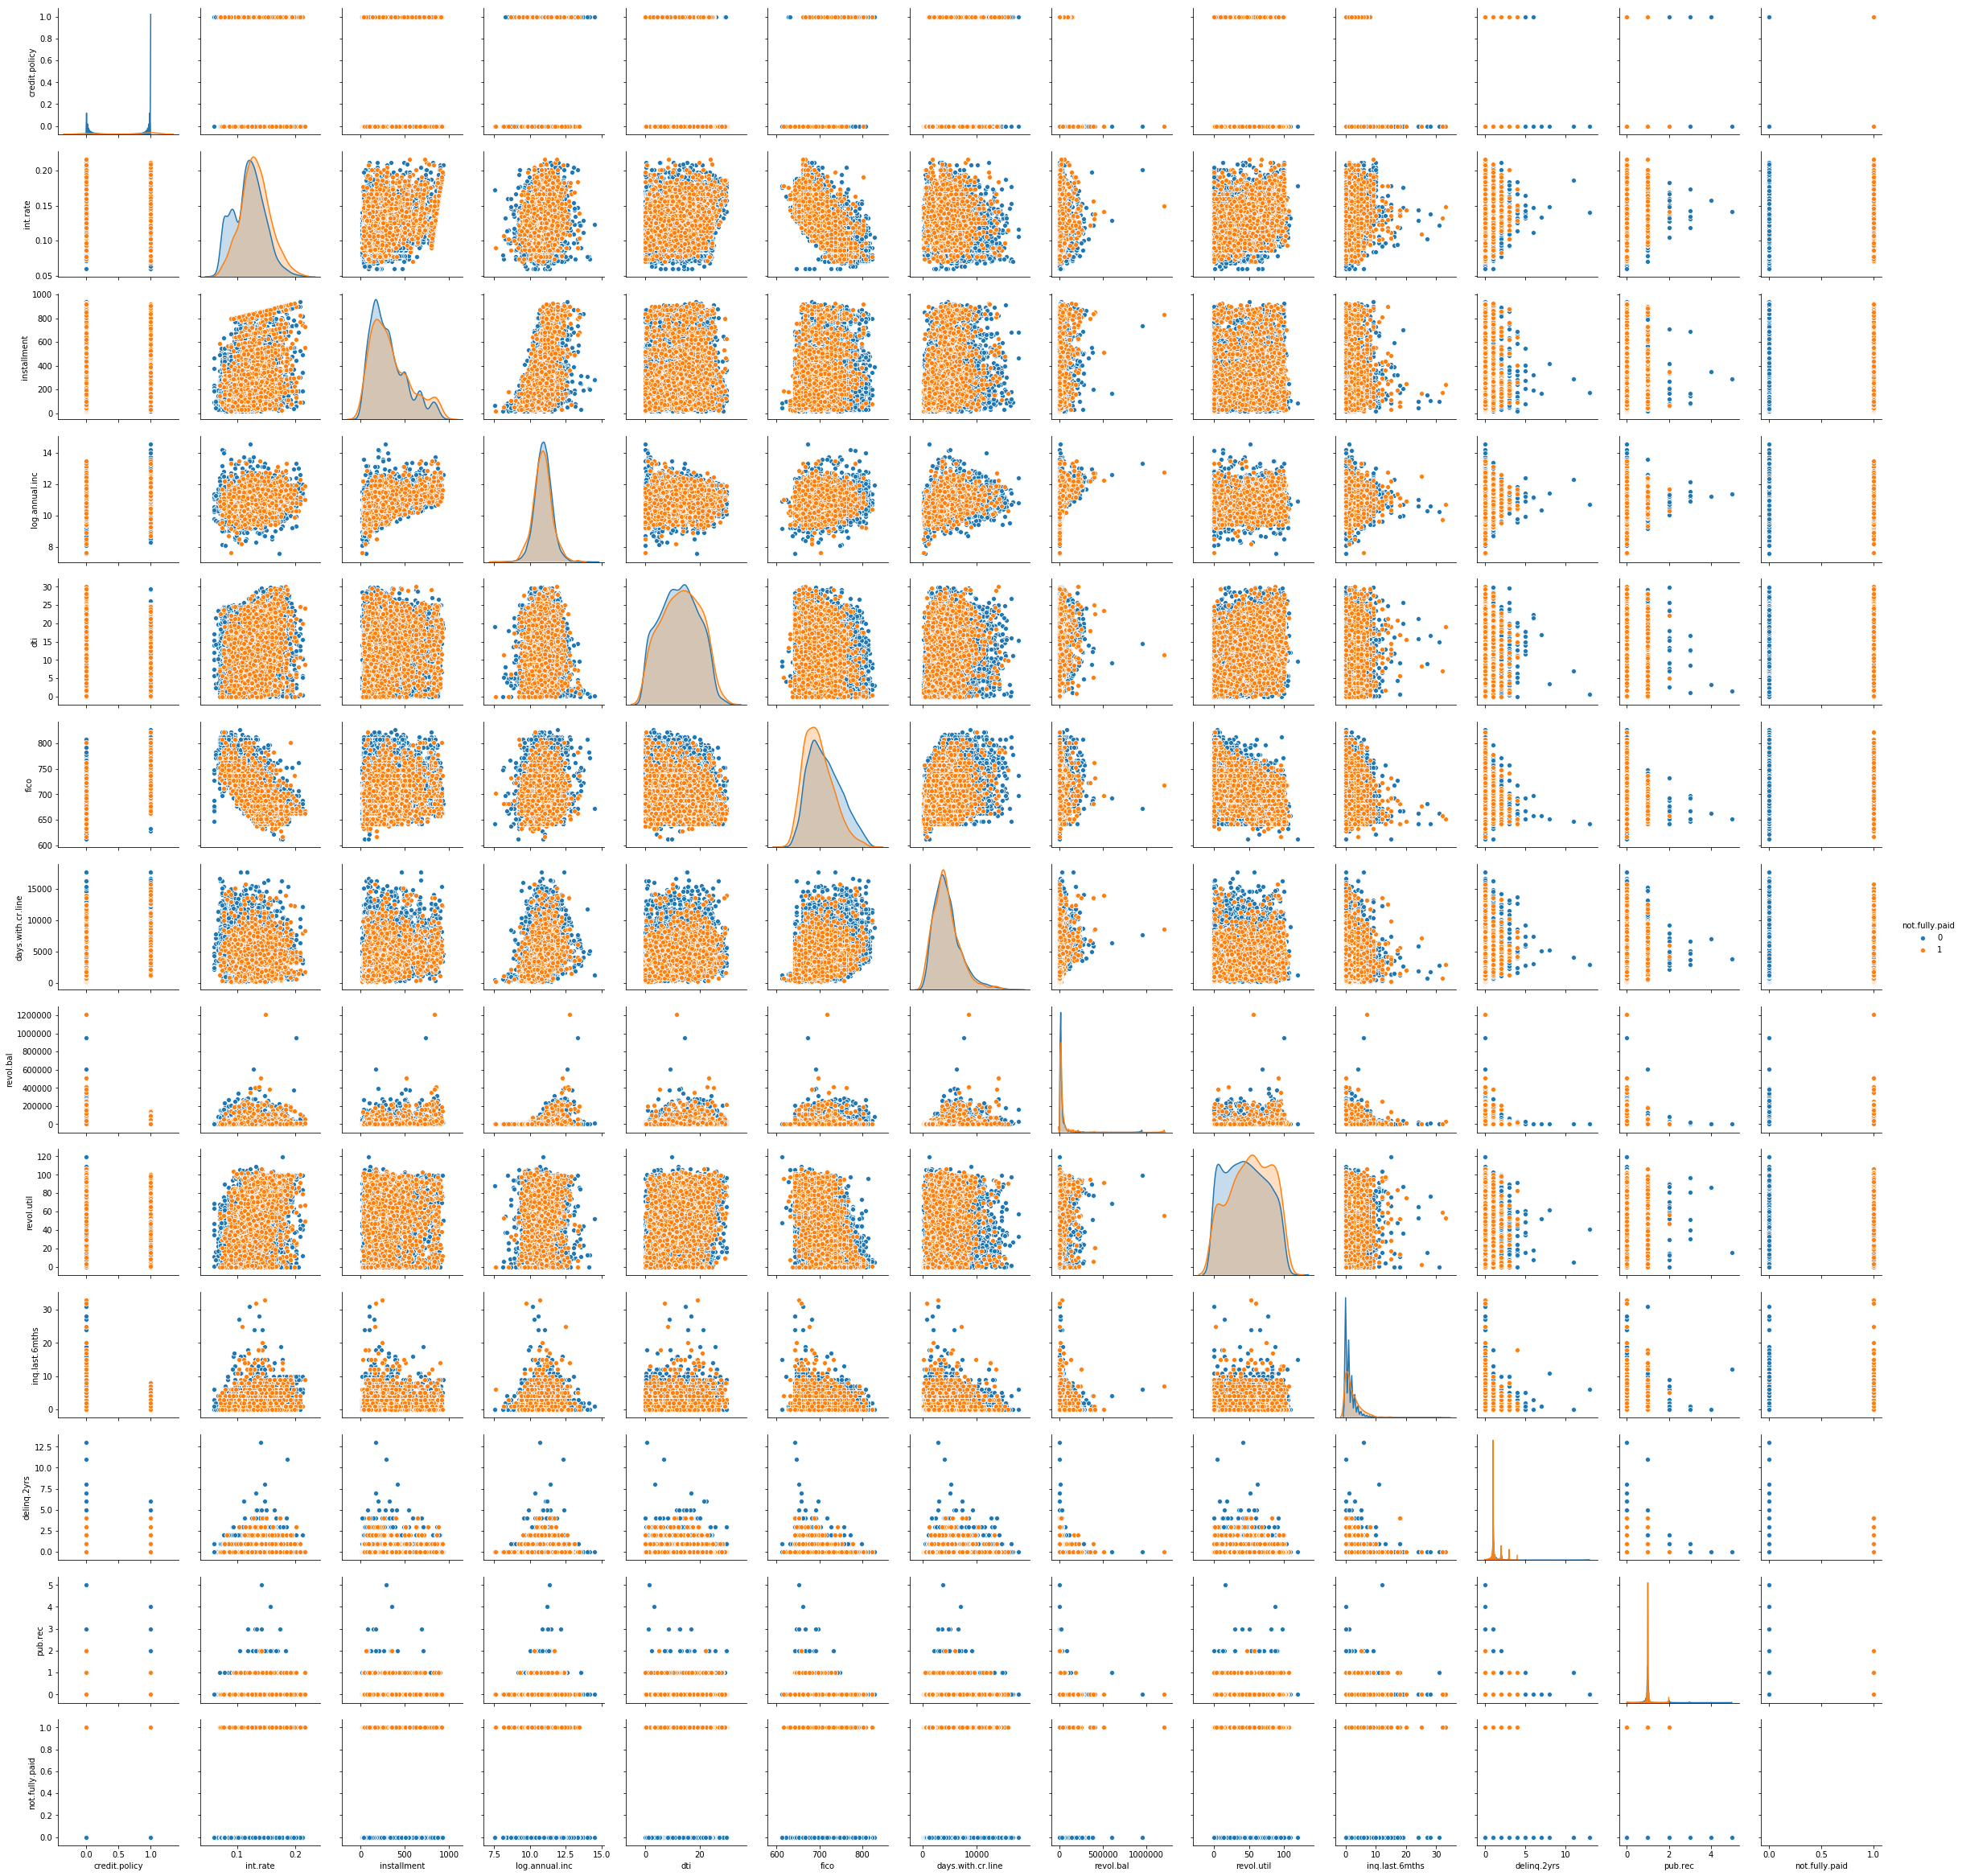

In [6]:
df_dropna = df.dropna()
sns.pairplot(df_dropna, hue = 'not.fully.paid')

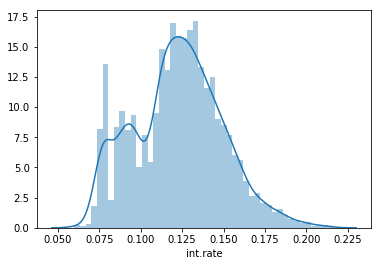

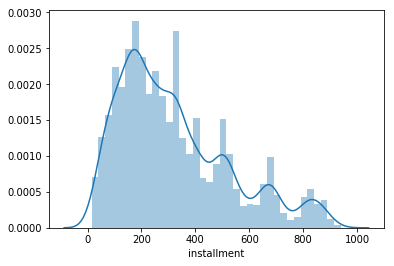

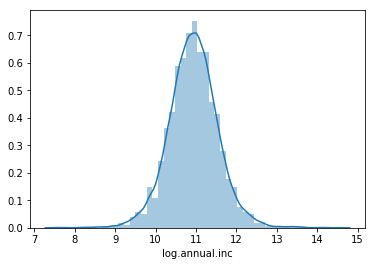

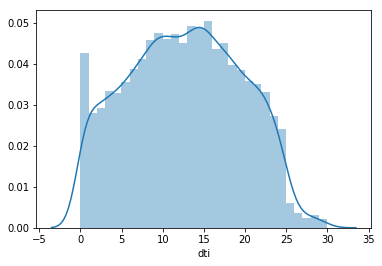

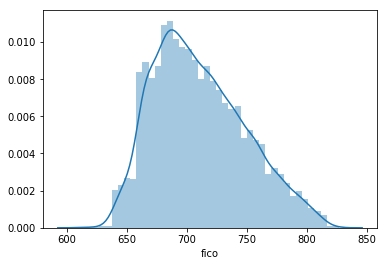

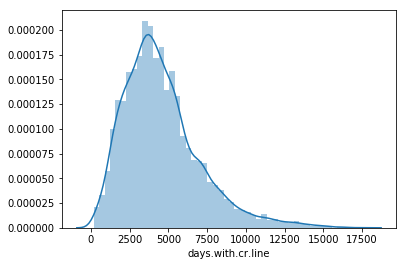

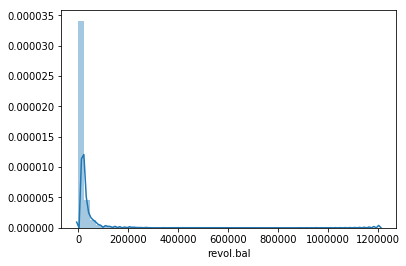

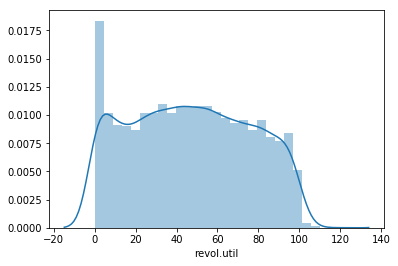

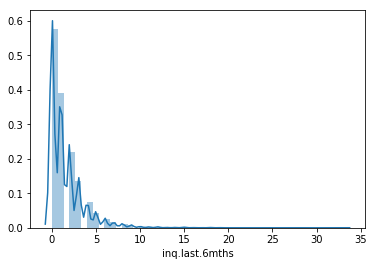

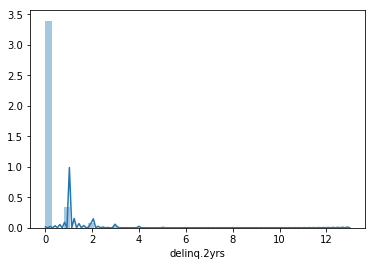

In [7]:
# check for numerical variables distribution
numerical_var = ["int.rate","installment","log.annual.inc","dti","fico","days.with.cr.line","revol.bal","revol.util",
                 "inq.last.6mths","delinq.2yrs" ]
for i, col in enumerate(numerical_var):
    plt.figure(i)
    sns.distplot(df_dropna[col])

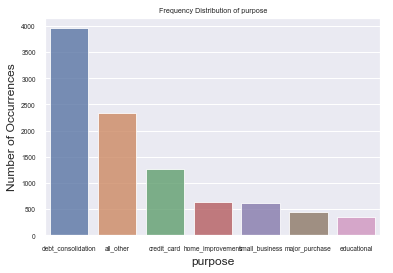

In [8]:
# check for categorical variable distribution
purpose_count = df['purpose'].value_counts()
sns.set(style="darkgrid")
sns.set(font_scale=0.6)
sns.barplot(purpose_count.index, purpose_count.values, alpha=0.8)
plt.title('Frequency Distribution of purpose')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('purpose', fontsize=12)
plt.show()

## check for correlation

In [9]:
sns.set(font_scale=1)
# check correlations
corr = df.corr()
corr

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
credit.policy,1.000000,-0.294089,0.058770,0.035752,-0.090901,0.348319,0.098730,-0.187518,-0.109876,-0.534757,-0.077141,-0.054501,-0.158119
int.rate,-0.294089,1.000000,0.276140,0.057119,0.220006,-0.714821,-0.124505,0.092527,0.463864,0.206677,0.156080,0.098394,0.159552
installment,0.058770,0.276140,1.000000,0.448523,0.050202,0.086039,0.183263,0.233625,0.079541,-0.008099,-0.004720,-0.032639,0.049955
log.annual.inc,0.035752,0.057119,0.448523,1.000000,-0.053434,0.113733,0.336077,0.372481,0.056112,0.028432,0.029409,0.016377,-0.033279
dti,-0.090901,0.220006,0.050202,-0.053434,1.000000,-0.241191,0.060231,0.188748,0.336578,0.031135,-0.022085,0.006102,0.037362
fico,0.348319,-0.714821,0.086039,0.113733,-0.241191,1.000000,0.263685,-0.015553,-0.541113,-0.187682,-0.216481,-0.147389,-0.149666
days.with.cr.line,0.098730,-0.124505,0.183263,0.336077,0.060231,0.263685,1.000000,0.229430,-0.024019,-0.042029,0.081707,0.071336,-0.028889
revol.bal,-0.187518,0.092527,0.233625,0.372481,0.188748,-0.015553,0.229430,1.000000,0.203002,0.023805,-0.033348,-0.031026,0.053699
revol.util,-0.109876,0.463864,0.079541,0.056112,0.336578,-0.541113,-0.024019,0.203002,1.000000,-0.011377,-0.042905,0.067375,0.082041
inq.last.6mths,-0.534757,0.206677,-0.008099,0.028432,0.031135,-0.187682,-0.042029,0.023805,-0.011377,1.000000,0.021183,0.073984,0.149954


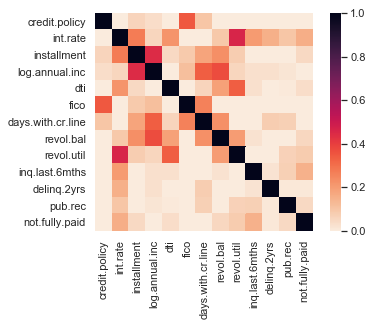

In [10]:
# Correlation Plot
sns.set()
np.random.seed(0)
cmap = sns.cm.rocket_r
ax = sns.heatmap(corr, vmin=0, vmax= 1, square=True, cmap = cmap, fmt=".3f")
plt.show()


## create dummy variable

In [11]:
# Create dummy variables from the feature purpose
df = pd.get_dummies(df, columns =["purpose"], drop_first=True)
df.head()
df.shape[1]

19

## Check missing value

In [12]:
# Check Missing Value
print df.isnull().sum()

credit.policy                  0
int.rate                       0
installment                    0
log.annual.inc                 4
dti                            0
fico                           0
days.with.cr.line             29
revol.bal                      0
revol.util                    62
inq.last.6mths                29
delinq.2yrs                   29
pub.rec                       29
not.fully.paid                 0
purpose_credit_card            0
purpose_debt_consolidation     0
purpose_educational            0
purpose_home_improvement       0
purpose_major_purchase         0
purpose_small_business         0
dtype: int64


In [13]:
# Create binary features to check if the observation has a missing value
for feature in df.columns:
    if np.any(np.isnan(df[feature])):
        df["is_" + feature + "_missing"] = np.isnan(df[feature]) * 1
df.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,...,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,is_log.annual.inc_missing,is_days.with.cr.line_missing,is_revol.util_missing,is_inq.last.6mths_missing,is_delinq.2yrs_missing,is_pub.rec_missing
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
# Original Data
X = df.loc[:, df.columns != "not.fully.paid"].values
Y = df.loc[:, df.columns == "not.fully.paid"].values.flatten()

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split test and training data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=True, random_state=123, stratify=Y)

print "Original train data shapes:" + str(X_train.shape)
print "Original test data shape:" + str(X_test.shape)

Original train data shapes:(7662, 24)
Original test data shape:(1916, 24)


In [15]:
# Drop NA and remove binary columns
train_indices_na = np.max(np.isnan(X_train), axis=1)
test_indices_na = np.max(np.isnan(X_test), axis=1)
X_train_dropna, Y_train_dropna = X_train[~train_indices_na, :][:, :-6], Y_train[~train_indices_na]
X_test_dropna, Y_test_dropna = X_test[~test_indices_na, :][:, :-6], Y_test[~test_indices_na]
print "After dropping NAs train data shape:" + str(X_train_dropna.shape)
print "After dropping NAs test data shape:" + str(X_test_dropna.shape)


After dropping NAs train data shape:(7611, 18)
After dropping NAs test data shape:(1905, 18)


## Build baseline model without missing value

In [16]:
#build baseline model Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=3,
                                criterion="entropy",
                                class_weight="balanced")
# calculate the auc score for Random Forest model 
scores = cross_val_score(rf_clf,
                         X_train_dropna, Y_train_dropna,
                         scoring="roc_auc", cv=5)
print "Baseline Random Forest model's average AUC:" + str(scores.mean())

#build baseline model for logistic regression model 
logR_clf = LogisticRegression(random_state=0, 
                              solver='liblinear',
                              multi_class='auto')
#calculate the AUC score for logistic regression model 
logReg_scores = cross_val_score(logR_clf,
                         X_train_dropna, Y_train_dropna,
                         scoring="roc_auc", cv = 10)
print "Baseline logistic model's average AUC:" + str(logReg_scores.mean())



Baseline Random Forest model's average AUC:0.65439724076091
Baseline logistic model's average AUC:0.670916227039316


## feature importance

/anaconda2/envs/laidata1/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


[1.61197211e-02 1.14070486e-01 1.11612038e-01 1.07636900e-01
 1.08405004e-01 8.86502629e-02 1.10549153e-01 1.07038083e-01
 1.07389135e-01 5.28874793e-02 1.70762731e-02 8.79893820e-03
 9.04943468e-03 1.33619859e-02 4.86527150e-03 6.53460323e-03
 5.40430877e-03 8.80468986e-03 1.28601297e-05 1.90995692e-04
 9.92883512e-04 1.99440295e-04 1.91641161e-04 1.58411995e-04]


Text(0.5,1,'Feature Importance')

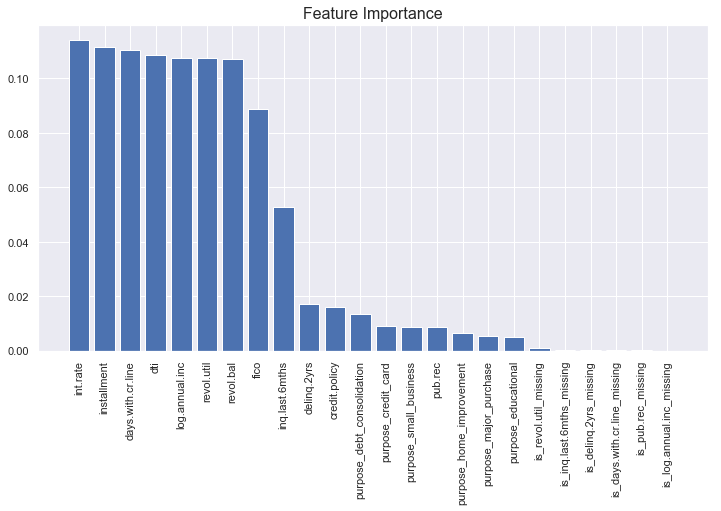

In [17]:
# Use Random Forest model to check the feature importance
rf_clf.fit(RobustScaler().fit_transform(Imputer(strategy="median").fit_transform(X_train)), Y_train)

# Plot features importance
importances = rf_clf.feature_importances_
print importances
indices = np.argsort(rf_clf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 25), importances[indices], align="center")
plt.xticks(range(1, 25), df.columns[df.columns != "not.fully.paid"][indices], rotation=90)
plt.title("Feature Importance", {"fontsize": 16})

In [18]:
# since using median value to substitute the missing value would result highest AUC score in RF model,
# Therefore, we sustitue the missing values with the median value of the data
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
imp_mean.fit(X_test)
SimpleImputer(copy=True, fill_value=None, missing_values=np.nan,
       strategy='mean', verbose=0)
X_train = imp_mean.transform(X_train)
X_test = imp_mean.transform(X_test)
X_train = X_train[:, :-6]
X_test = X_test[:, :-6]

In [19]:
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=3,
                                criterion="entropy",
                                class_weight="balanced")
# calculate the auc score for Random Forest model 
scores = cross_val_score(rf_clf,
                         X_train, Y_train,
                         scoring="roc_auc", cv=5)
print "Baseline Random Forest model's average AUC:" + str(scores.mean())


Baseline Random Forest model's average AUC:0.6544923921497547


## Modeling

### Random Forest Model 

In [20]:
# 　construct a randomforest model
rf_clf_df = RandomForestClassifier(random_state=123)

resampled_rf_df = BalancedBaggingClassifier(base_estimator=rf_clf_df,
                                         n_estimators=10, random_state=123)
resampled_rf_df.fit(X_train, Y_train)
rf_pred_df = resampled_rf_df.predict(X_test) 
rf_cm_df = confusion_matrix(Y_test, rf_pred_df)
rf_ac_df = accuracy_score(Y_test, rf_pred_df)
rf_probs_df = resampled_rf_df.predict_proba(X_test)[:, 1:]
rf_auc_score_df = roc_auc_score(Y_test, rf_probs_df)
fpr, tpr, _ = roc_curve(Y_test, rf_probs_df)
precision, recall, _ = precision_recall_curve(Y_test, rf_probs_df)
rdf_cm=confusion_matrix(Y_test,rf_pred_df)


/anaconda2/envs/laidata1/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6873986513159893
0.7072025052192067


<Figure size 1152x576 with 0 Axes>

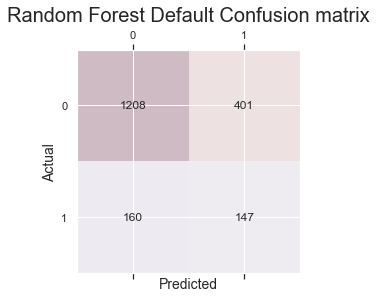

In [21]:
# confusion matrix for default random forest model
plt.figure(figsize=(16, 8))
plt.matshow(rf_cm_df, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=rf_cm_df[i, j], ha="center", va="center")
plt.title("Random Forest Default Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});
print rf_auc_score_df
print rf_ac_df

In [22]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [23]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# #rf = RandomForestClassifier(n_estimators=500,
#                                 max_features="sqrt",
#                                 criterion="entropy",
#                                 class_weight="balanced")

# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# #rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# #rf_random.fit(X_train, Y_train)


IndentationError: unexpected indent (<ipython-input-23-47a01304b8b2>, line 4)

In [ ]:
# rf_random.best_params_

In [24]:
# 　construct a optimized random forest model
rf_clf = RandomForestClassifier(n_estimators=2000,
                                max_features="sqrt",
                                criterion="entropy",
                                class_weight="balanced",
                               min_samples_leaf=1,
                               min_samples_split=5,
                               bootstrap = True)

resampled_rf = BalancedBaggingClassifier(base_estimator=rf_clf,
                                         n_estimators=10, random_state=123)
resampled_rf.fit(X_train, Y_train)
rf_pred = resampled_rf.predict(X_test) 
rf_cm = confusion_matrix(Y_test, rf_pred)
rf_ac = accuracy_score(Y_test, rf_pred)
rf_probs = resampled_rf.predict_proba(X_test)[:, 1:]
rf_auc_score = roc_auc_score(Y_test, rf_probs)
fpr, tpr, _ = roc_curve(Y_test, rf_probs)
precision, recall, _ = precision_recall_curve(Y_test, rf_probs)


0.695092547417519
0.704070981210856


<Figure size 1152x576 with 0 Axes>

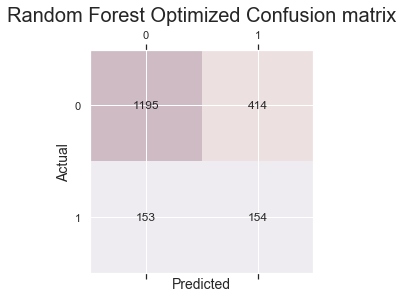

In [25]:
plt.figure(figsize=(16, 8))
plt.matshow(rf_cm, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=rf_cm[i, j], ha="center", va="center")
plt.title("Random Forest Optimized Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});
print rf_auc_score
print rf_ac

### Logisitc Regression

0.7038624350406812
[[1023  586]
 [ 114  193]]


/anaconda2/envs/laidata1/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


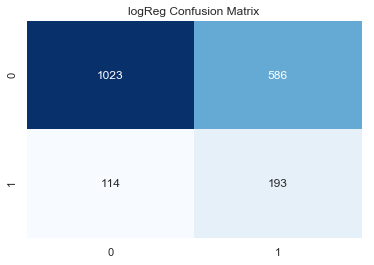

In [26]:
# 　construct a logistict model by default
lg_clf = LogisticRegression(random_state=123)

resampled_lg = BalancedBaggingClassifier(base_estimator=lg_clf,
                                         n_estimators=10, random_state=123)
resampled_lg.fit(X_train, Y_train)
lg_pred = resampled_lg.predict(X_test) 
lg_cm = confusion_matrix(Y_test, lg_pred)
lg_ac = accuracy_score(Y_test, lg_pred)
lg_probs = resampled_lg.predict_proba(X_test)[:, 1:]
lg_auc_score = roc_auc_score(Y_test, lg_probs)
fpr, tpr, _ = roc_curve(Y_test, lg_probs)
precision, recall, _ = precision_recall_curve(Y_test, lg_probs)
lg_cm=confusion_matrix(Y_test,lg_pred)
plt.title("logReg Confusion Matrix")
sns.heatmap(lg_cm,annot=True,cmap="Blues",fmt="d",cbar=False)
print lg_auc_score
print lg_cm

/anaconda2/envs/laidata1/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


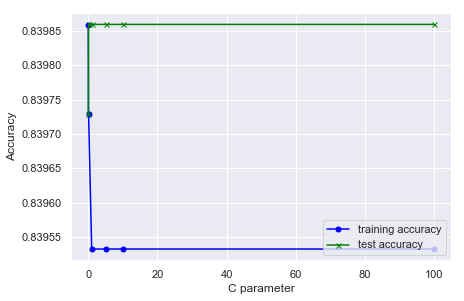

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve

C_param_range = [0.001,0.1,1,5,10,100]
plt.figure(figsize=(15, 10))
for i in C_param_range:
    # Apply logistic regression model to training data
    lr = LogisticRegression(penalty='l2',C = i,random_state = 0)

train_scores, test_scores = validation_curve(estimator=lr
                                            ,X=X_train
                                            ,y=Y_train
                                            ,param_name='C'
                                            ,param_range= C_param_range
                                            )
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.subplot(2,2,1)
plt.plot(C_param_range
            ,train_mean
            ,color='blue'
            ,marker='o'
            ,markersize=5
            ,label='training accuracy')
    
plt.plot(C_param_range
            ,test_mean
            ,color='green'
            ,marker='x'
            ,markersize=5
            ,label='test accuracy') 
plt.xlabel('C parameter')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


0.701850138573132
0.6304801670146137


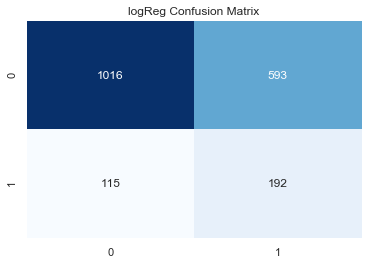

In [28]:
# 　construct a logistict model by default
lg_clf = LogisticRegression(penalty = 'l2',C = 0.01, random_state=123)

resampled_lg = BalancedBaggingClassifier(base_estimator=lg_clf,
                                         n_estimators=10, random_state=123)
resampled_lg.fit(X_train, Y_train)
lg_pred = resampled_lg.predict(X_test) 
lg_cm = confusion_matrix(Y_test, lg_pred)
lg_ac = accuracy_score(Y_test, lg_pred)
lg_probs = resampled_lg.predict_proba(X_test)[:, 1:]
lg_auc_score = roc_auc_score(Y_test, lg_probs)
fpr, tpr, _ = roc_curve(Y_test, lg_probs)
precision, recall, _ = precision_recall_curve(Y_test, lg_probs)
lg_cm=confusion_matrix(Y_test,lg_pred)
plt.title("logReg Confusion Matrix")
sns.heatmap(lg_cm,annot=True,cmap="Blues",fmt="d",cbar=False)

print lg_auc_score
print lg_ac

<Figure size 1152x576 with 0 Axes>

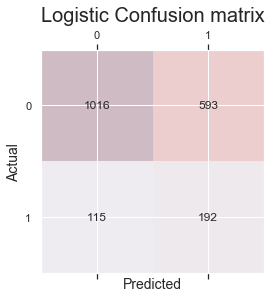

In [29]:
plt.figure(figsize=(16, 8))
plt.matshow(lg_cm, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=lg_cm[i, j], ha="center", va="center")
plt.title("Logistic Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

/anaconda2/envs/laidata1/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.6736020714102069


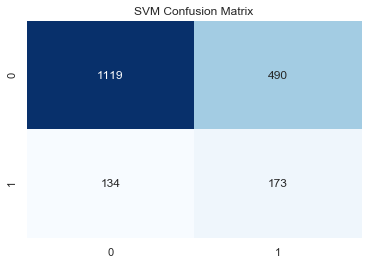

In [30]:
svm_clf = SVC(kernel="rbf")
resampled_svm = BalancedBaggingClassifier(base_estimator=svm_clf,
                                         n_estimators=10, random_state=123)
resampled_svm.fit(X_train, Y_train)
svm_pred = resampled_svm.predict(X_test) 
svm_cm = confusion_matrix(Y_test, svm_pred)
svm_ac = accuracy_score(Y_test, svm_pred)
svm_probs = resampled_svm.predict_proba(X_test)[:, 1:]
svm_auc_score = roc_auc_score(Y_test, svm_probs)
fpr, tpr, _ = roc_curve(Y_test, svm_probs)
precision, recall, _ = precision_recall_curve(Y_test, svm_probs)
svm_cm=confusion_matrix(Y_test,svm_pred)
plt.title("SVM Confusion Matrix")
sns.heatmap(svm_cm,annot=True,cmap="Blues",fmt="d",cbar=False)
print svm_auc_score

<Figure size 1152x576 with 0 Axes>

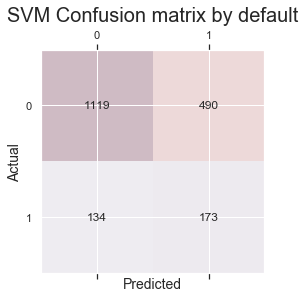

In [31]:
plt.figure(figsize=(16, 8))
plt.matshow(svm_cm, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=svm_cm[i, j], ha="center", va="center")
plt.title("SVM Confusion matrix by default", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

In [32]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]
# parameters = {'C':Cs, 'gamma': gammas}
# svc = svm.SVC(gamma="scale")
# clf = GridSearchCV(svc, parameters, cv=5)
# clf.fit(X_train,Y_train)
# clf.get_params

In [33]:
# print('Best C:',clf.best_estimator_.C) 
# print('Best Kernel:',clf.best_estimator_.kernel)
# print('Best Gamma:',clf.best_estimator_.gamma)

0.6799729939286951


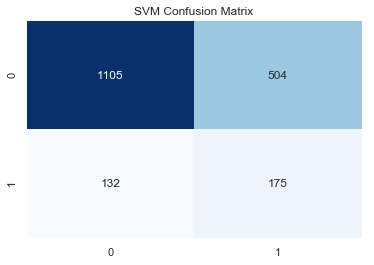

In [34]:
svm_clf = SVC(kernel="rbf",C = 10, gamma = 0.01)
resampled_svm = BalancedBaggingClassifier(base_estimator=svm_clf,
                                         n_estimators=10, random_state=123)
resampled_svm.fit(X_train, Y_train)
svm_pred = resampled_svm.predict(X_test) 
svm_cm = confusion_matrix(Y_test, svm_pred)
svm_ac = accuracy_score(Y_test, svm_pred)
svm_probs = resampled_svm.predict_proba(X_test)[:, 1:]
svm_auc_score = roc_auc_score(Y_test, svm_probs)
fpr, tpr, _ = roc_curve(Y_test, svm_probs)
precision, recall, _ = precision_recall_curve(Y_test, svm_probs)
svm_cm=confusion_matrix(Y_test,svm_pred)
plt.title("SVM Confusion Matrix")
sns.heatmap(svm_cm,annot=True,cmap="Blues",fmt="d",cbar=False)
print svm_auc_score

<Figure size 1152x576 with 0 Axes>

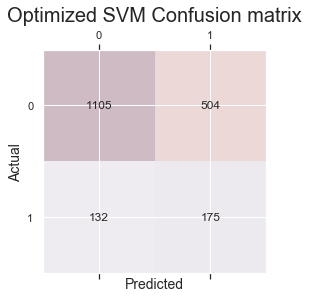

In [35]:
plt.figure(figsize=(16, 8))
plt.matshow(svm_cm, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=svm_cm[i, j], ha="center", va="center")
plt.title("Optimized SVM Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

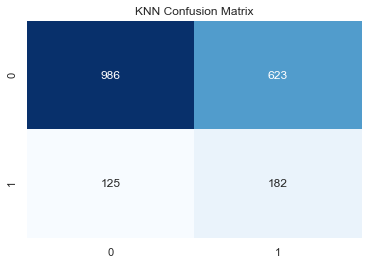

In [36]:
from sklearn.neighbors import KNeighborsClassifier  
knn_clf = KNeighborsClassifier(n_neighbors=10)  
resampled_knn = BalancedBaggingClassifier(base_estimator=knn_clf,
                                         n_estimators=10, random_state=123)

resampled_knn.fit(X_train, Y_train)
knn_pred = resampled_knn.predict(X_test) 
knn_cm = confusion_matrix(Y_test, knn_pred)
knn_ac = accuracy_score(Y_test, knn_pred)
knn_probs = resampled_knn.predict_proba(X_test)[:, 1:]
knn_auc_score = roc_auc_score(Y_test, knn_probs)
fpr, tpr, _ = roc_curve(Y_test, knn_probs)
precision, recall, _ = precision_recall_curve(Y_test, knn_probs)
knn_cm=confusion_matrix(Y_test,knn_pred)
plt.title("KNN Confusion Matrix")
sns.heatmap(knn_cm,annot=True,cmap="Blues",fmt="d",cbar=False)


<Figure size 1152x576 with 0 Axes>

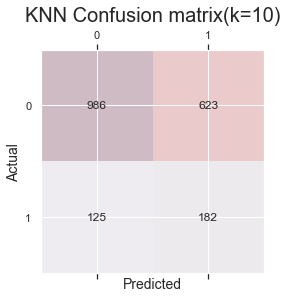

In [37]:
plt.figure(figsize=(16, 8))
plt.matshow(knn_cm, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=knn_cm[i, j], ha="center", va="center")
plt.title("KNN Confusion matrix(k=10)", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

In [38]:
error = []

# Calculating error for K values between 1 and 30
for i in range(1, 30):  
    knn = KNeighborsClassifier(n_neighbors=i)
    resampled_knn = BalancedBaggingClassifier(base_estimator=knn,
                                         n_estimators=10, random_state=123)
    resampled_knn.fit(X_train, Y_train)
    pred_i = resampled_knn.predict(X_test)
    error.append(np.mean(pred_i != Y_test))

Text(0,0.5,'Mean Error')

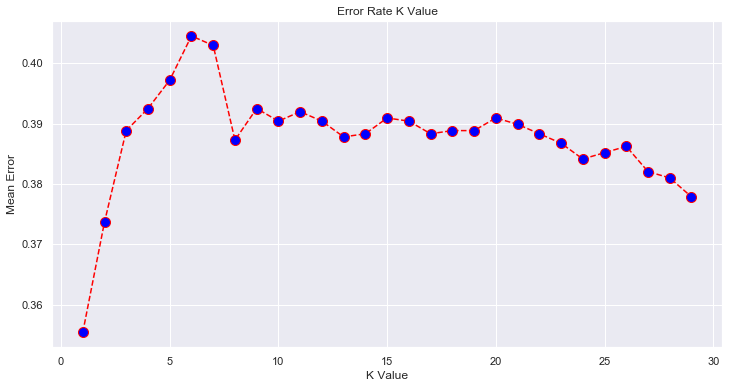

In [39]:
# Find the optimized K for KNN model
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 30), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

In [40]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(Y_test, knn_pred))  
print(classification_report(Y_test, knn_pred))  

[[986 623]
 [125 182]]
              precision    recall  f1-score   support

           0       0.89      0.61      0.73      1609
           1       0.23      0.59      0.33       307

   micro avg       0.61      0.61      0.61      1916
   macro avg       0.56      0.60      0.53      1916
weighted avg       0.78      0.61      0.66      1916



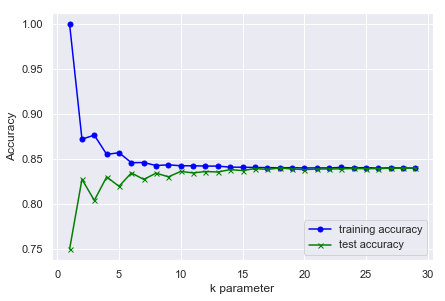

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve

k_param_range = [i for i in range(1,30)]
plt.figure(figsize=(15, 10))
for i in k_param_range:
    # Apply logistic regression model to training data
    knn = KNeighborsClassifier(n_neighbors = i)

train_scores, test_scores = validation_curve(estimator=knn
                                            ,X=X_train
                                            ,y=Y_train
                                            ,param_name='n_neighbors'
                                            ,param_range=k_param_range
                                            )
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.subplot(2,2,1)
plt.plot(k_param_range
            ,train_mean
            ,color='blue'
            ,marker='o'
            ,markersize=5
            ,label='training accuracy')
    
plt.plot(k_param_range
            ,test_mean
            ,color='green'
            ,marker='x'
            ,markersize=5
            ,label='test accuracy') 
plt.xlabel('k parameter')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


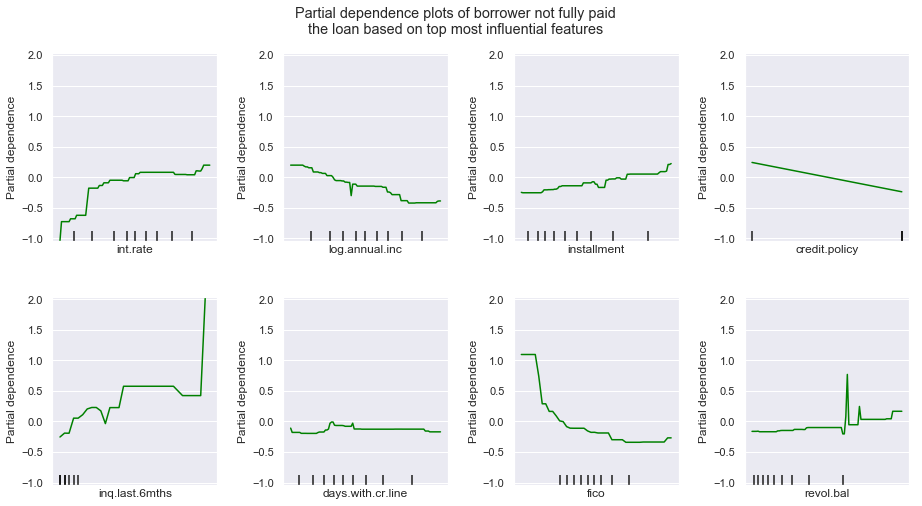

In [42]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
gbrt = GradientBoostingClassifier(loss="deviance",
                                  learning_rate=0.1,
                                  n_estimators=100,
                                  max_depth=3,
                                  random_state=123)
gbrt.fit(X_train, Y_train)
fig, axes = plot_partial_dependence(gbrt,
                                    X_train,
                                    np.argsort(gbrt.feature_importances_)[::-1][:8],
                                    n_cols=4,
                                    feature_names=df.columns[:-6],
                                    figsize=(14, 8))
plt.subplots_adjust(top=0.9)
plt.suptitle("Partial dependence plots of borrower not fully paid\n" + 
             "the loan based on top most influential features")
for ax in axes:
  ax.set_xticks(())

In [43]:
models = {"rf": resampled_rf, "svm": resampled_svm, "logistic": resampled_lg, "knn": resampled_knn}

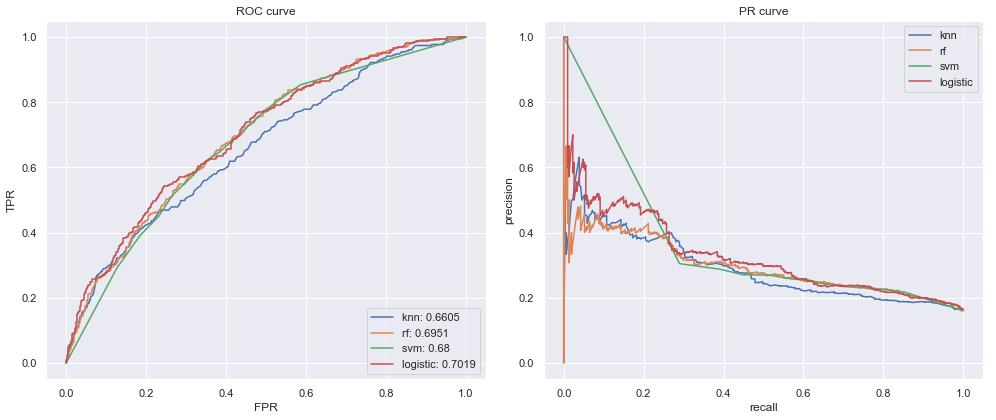

In [44]:
resampled_rf.fit(X_train, Y_train)
resampled_lg.fit(X_train, Y_train)
resampled_svm.fit(X_train, Y_train)
resampled_knn.fit(X_train, Y_train)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for name, model in models.items():
            model_probs = model.predict_proba(X_test)[:, 1:]
            model_auc_score = roc_auc_score(Y_test, model_probs)
            fpr, tpr, _ = roc_curve(Y_test, model_probs)
            precision, recall, _ = precision_recall_curve(Y_test, model_probs)
            l = str(name) + ": " + str(round(model_auc_score,4))
            axes[0].plot(fpr, tpr, label = l )
            axes[1].plot(recall, precision, label = name)
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()

In [45]:
print "random forest auc Score: " + str(rf_auc_score)
print "logistic regression auc Score: " + str(lg_auc_score)
print "svm auc Score: " + str(svm_auc_score)
print "knn auc Score: " + str(knn_auc_score)

random forest auc Score: 0.695092547417519
logistic regression auc Score: 0.701850138573132
svm auc Score: 0.6799729939286951
knn auc Score: 0.6492561183732386


In [46]:
print "random forest Accuracy: "+ str(rf_ac)
print "logistic regression Accuracy: "+ str(lg_ac)
print "svm Accuracy: "+ str(svm_ac)
print "knn Accuracy: "+ str(knn_ac)

random forest Accuracy: 0.704070981210856
logistic regression Accuracy: 0.6304801670146137
svm Accuracy: 0.6680584551148225
knn Accuracy: 0.6096033402922756


In [47]:
LRmodel_l2 = LogisticRegression(penalty="l2")
LRmodel_l2.fit(X_train, Y_train)
LRmodel_l2.coef_[0]

print ("Logistic Regression (L2) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l2.coef_[0]), \
                      df.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
   print (v + ": " + str(k))

Logistic Regression (L2) Coefficients
fico: -0.3513
installment: 0.2435
log.annual.inc: -0.2182
purpose_credit_card: -0.1604
not.fully.paid: -0.1596
credit.policy: -0.1457
inq.last.6mths: 0.1427
purpose_major_purchase: 0.1365
purpose_home_improvement: -0.0991
pub.rec: 0.0707
revol.bal: 0.0704
delinq.2yrs: -0.0703
revol.util: 0.0432
int.rate: 0.0417
days.with.cr.line: 0.0308
purpose_educational: 0.0222
purpose_debt_consolidation: 0.0091
dti: -0.0029
